# Homework 2 - Evidence Accumulation

This homework has two main parts:

- First, we will build off the lab by exploring the relationship between decision threshold (one of the DDM parameters) and the performance of an accumulating agent.
- Second, we will take a brief look at the role of randomness in the exploratory behavior of a sniffing agent.

## Section - Setup

### Install explorationlib, import modules, configure notebook

In [1]:
# ADMCode uses an old version of numba
!pip install numba==0.48
!pip install --upgrade git+https://github.com/clappm/AdaptiveDecisionMaking_2018
!pip install --upgrade git+https://github.com/parenthetical-e/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git
!pip install celluloid # for the gifs

from __future__ import division
from ADMCode import visualize as vis
from ADMCode import ddm, sdt

import numpy as np
import pandas as pd

from ipywidgets import interactive
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Import misc
import shutil
import glob
import os
import copy
import sys

# Vis - 1
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Exp
from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

# Agents
from explorationlib.agent import DiffusionDiscrete
from explorationlib.agent import GradientDiffusionGrid
from explorationlib.agent import GradientDiffusionDiscrete
from explorationlib.agent import AccumulatorGradientGrid
from explorationlib.agent import TruncatedLevyDiscrete

# Env
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import constant_values

# Vis - 2
from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid

# Score
from explorationlib.score import total_reward
from explorationlib.score import num_death

# Pretty plots
warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")
sns.set(style='white', font_scale=1.3)

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

     |████████████████████████████████| 3.5 MB 5.4 MB/s 
     |████████████████████████████████| 20.2 MB 1.5 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
  Cloning https://github.com/clappm/AdaptiveDecisionMaking_2018 to /tmp/pip-req-build-2onfu1mt
  Running command git clone -q https://github.com/clappm/AdaptiveDecisionMaking_2018 /tmp/pip-req-build-2onfu1mt
  Created wheel for ADMCode: filename=ADMCode-0.5.2-py3-none-any.whl size=39223 sha256=6be65b1179e34dd3fdac122d682b165222bf5ffd82bd8ed37a1eaa5dd6ab0530
  Stored in directory: /tmp/pip-ephem-wheel-cache-5lsxnhxi/wheels/39/45/1c/971b7fac68419e436447919c986b425b87e4ab1ed2d33d9fa4
Successfully built ADMCode
  Cloning https://github.com/parenthetical-e/explorationli

/usr/local/lib/python3.7/dist-packages/explorationlib/run.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


pygame 2.0.1 (SDL 2.0.14, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Section - Influence of Threshold on Performance [60 pts total]

How does decision thershold influence behavior? Here, we will perform a parameter sweep over the decision threshold to see how the agent is affected in a basic sniffing task.

For this section, you will need to slightly modify the lab code to loop over a list of thresholds rather than a list of drift rates.

### Define shared parameters and initialize environment [5 pts]

In [2]:
# Shared exp parameters
num_steps = 200
max_steps = 10
seed_value = 5838

min_length = 1
step_size = 0.1

noise_sigma = 2
detection_radius = 1
num_targets = 250 
target_boundary = (100, 100)

# Env
env = ScentGrid(mode=None)
env.seed(seed_value)

# Targets
prng = np.random.RandomState(seed_value)
targets = uniform_targets(num_targets, target_boundary, prng=prng)
values = constant_values(targets, 1)

# Scents
coord, scent = create_grid_scent(target_boundary, amplitude=1, sigma=10)
scents = [scent for _ in range(len(targets))]
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

### Create a list of thresholds to test [5 pts]

Select at least 5 values.  For reference, the lab used a threshold of 3.

In [3]:
# Our parameters 
thresholds = [1.0, 2.0, 3.0, 4.0, 5.0]

# For plotting
colors = ["darkgreen", "seagreen", "cadetblue", "steelblue", "mediumpurple"]
names = thresholds # list(range(5))

### Run 100 experiments for each threshold [10 pts]

Use a drift rate of 1.0, the middle value from the lab.

In [4]:
# Exp params
drift_rate = 1.0
accumulate_sigma = 1.0

num_experiments = 100

# Run
results = []
for i, threshold in zip(names, thresholds):
    accum = AccumulatorGradientGrid(
        min_length=min_length, 
        max_steps=max_steps, 
        threshold=threshold, 
        drift_rate=drift_rate,
        accumulate_sigma=accumulate_sigma
    )
    accum.seed(seed_value)
    # !
    exp = experiment(
        f"accum_{i}",
        accum,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=True,
        seed=seed_value
    )
    results.append(exp)

accum_1:   0%|          | 0/100 [00:00<?, ?it/s]

accum_2:   0%|          | 0/100 [00:00<?, ?it/s]

accum_3:   0%|          | 0/100 [00:00<?, ?it/s]

accum_4:   0%|          | 0/100 [00:00<?, ?it/s]

accum_5:   0%|          | 0/100 [00:00<?, ?it/s]

### Create plots of distance traveled, number of deaths, best score, and average score [10 pts]

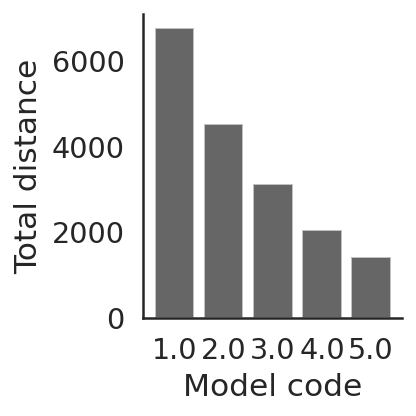

In [5]:
# Distance Traveled
# Score
scores = []
for result in results:  
    l = 0.0
    for r in result:
        l += r["agent_total_l"][-1]
    scores.append(l)   

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))

# -
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Total distance")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

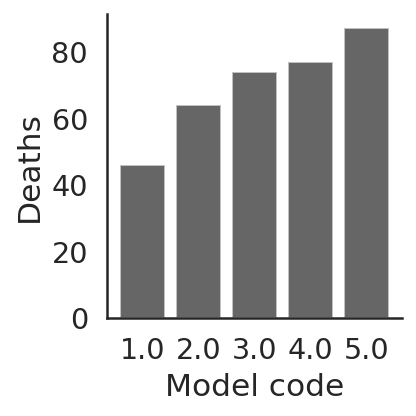

In [6]:
# Deaths
# Score
scores = []
for result in results:
    scores.append(num_death(result))   

# -
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], scores, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

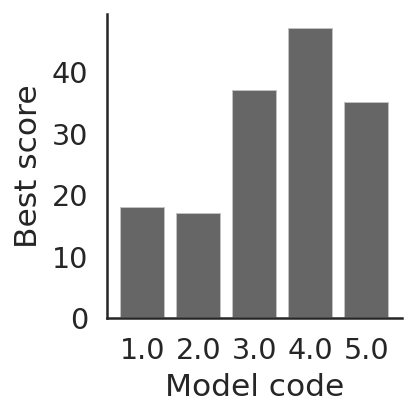

In [7]:
#Best Score
# Score
scores = []
for result in results:
    r = total_reward(result)
    scores.append(r)   

# Tabulate
m = []
for s in scores:
    m.append(np.max(s))

# -
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Best score")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

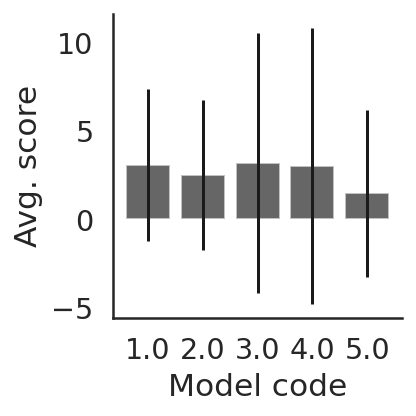

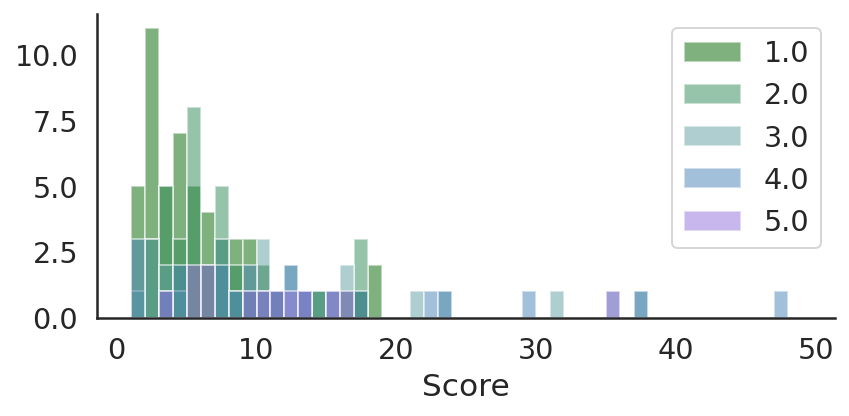

In [9]:
# Score
scores = []
for result in results:  
    r = total_reward(result)
    scores.append(r)   

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Avg. score")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

# Dists of means
fig = plt.figure(figsize=(6, 3))
for (i, s, c) in zip(names, scores, colors):
    plt.hist(s, label=i, color=c, alpha=0.5, bins=list(range(1,50,1)))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

### Question 1 [15 pts]

Based on the plots above and in your own words, summarize the relationship between the decision _threshold_ and the total distance, number of deaths, best reward and average reward.  How do the effects of increasing threshold compare to the effects of increasing drift rate (from the example in lab)?

**Total Distance:** *The higher the threshold the shorter the total distance travelled. This is the opposite of how drift rate affects total distance: when drift rate increases so does the total distance travelled.*

**Deaths:** *The higher the threshold the more deaths there were. This is also the opposite of how drift rate affects death: when drift rate increases, the number of deaths decrease.*

**Best Score:** *The best score had a kind of bell curve pattern with the peak threshold at 4.0 (Maya's graph which had a wider range of threshold values also showed this pattern which further emphasized my original thought). The drift rate seems to have a less consistent affect on the best score, with a general pattern being the a low drift rate has a lower best score but without enough evidence to show a strong correlation.*

**Average Score:** *The average score seems to have essentially no correlation to the threshold value because they are all very similar with the edge values of the threshold (with the center being 4.0) are more consistent in a lower range of scores while the threshold of 4.0 has a larger range. This seemed very similar to how drift rate affected the average score (no correlation and a range increase near the middle values).*

### Question 2 [10 pts]

Based on your observations, do you think an accumulator is needed for this *particular* task setup?  Would you expect an agent which doesn't accumulate (having a threshold of almost zero, thus reacting immediately to its first sensory signal) to outform an agent which uses multiple time steps to accumulate evidence?

*No, I do not think an accumulator is "needed" for this particular task. An accumulator only makes a difference for higher threshold values, while for lower ones having an accumulator barely makes a difference. Since the lower thresholds have a high survival rate with decent average score, the accumulator is unecessary.*

*No, an agent lacking an accumulator would preform worse than one with an accumulator if we looking at a large amount of time/steps. For a small amount like in this task, however, both agents would preform very similarly with a threshold of almost 0.*

### Question 3 [5 pts]

Let's get philosophical. Is it better to gamble on being the best, knowing you risk death (in this task) or is it better to be average and alive? 

Based on the data from lab and this homework, what DDM parameters (drift rate, decision threshold) do you _personally_ prefer? There is no right answer. Be yourself.

*Average and alive is overall a safer bet on a purely instictual basis. If you think about how we live life, however, humans often take risks to try to be the best. For example even a higher level college, like CMU, is a risk from a financial standpoint as well as a health/stress level standpoint, and yet we take the risk in order to (hopefully) increase our chances of landing out dream (best) job.*

*I personally would go for a threshhold of 3.0 (basic, I know) because it has the highest average score, a decent best score (so you have decent self-esteem), and a low death count. Total distance I think matters least to me so I personally ignored that parameeter. And for drift rate I would choose 1.0 (basic again) for the same reasons. Basically I would rather stay alive than die trying to be the best, but I also am willing to have a slight risk of death if it means I am not miserable.*

## Section - Is randomness still important for movement? [40 pts total]

Let's take a break from evidence accumulation to revisit the simpler sniffing agent, which automatically knows the gradient direction without having to decide first.

Recall that the movement of these sniffing agents is also governed by two other parameters: _p pos_ and _p neg_.  These represent the probability that the agent changes its direction before its linear movement.

- If the gradient is positive at the current location, then _p pos_ is the chance of changing direction.
- If the gradient is negative, then _p neg_ is the chance of changing direction.

### Question 4 [10 pts]
In the example in lab, _p pos_ was 0.5, and _p neg_ was 1.0. This means that when the gradient was positive half the time the walker would change direction anyway. It also means the all the time when the grad was negative, the explorer would change direction.

Do these parameter choices seem optimal to you? 

Make a best guess for how to improve them, if you think they can be improved. Explain your choice.

I think that p neg should always be 1.0 becuase if you are going in the wrong direction than you must change direction. On the other hand, p pos should be lower in my opinion, perhaps 0.1, because if you are already going in the right direction then you only want a slight chance of changing the direction which would allow for shortcuts, otherwise there will be too much accidental turning away from your goal if the p pos is too high.

### Testing your hypothesis [15 pts]

By (very slightly) modifying the parameters of the code from lab, rerun the comparison between diffusion, levy, and sniffing agents, but with a better selection for _p pos_ and _p neg_.  Then plot the results.

test4_levy:   0%|          | 0/100 [00:00<?, ?it/s]

test4_diff:   0%|          | 0/100 [00:00<?, ?it/s]

test4_sniff:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

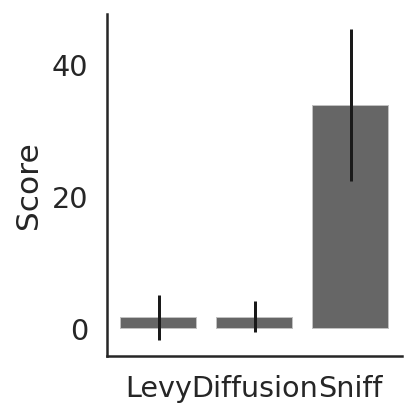

In [14]:
# Experiment settings
num_experiments = 100
num_steps = 1000
p_neg = 1.0
p_pos = .1
scent_sigma = 10


# Env
detection_radius = 1
min_length = 1
max_length = 10

env = ScentGrid(mode="discrete")
boundary = (100, 100)
target = (5,5)
coord, scent = create_grid_scent(boundary, amplitude=1, sigma=scent_sigma)
env.add_scent(target, 1, coord, scent)
# TODO plot scent

# Agents
diff = DiffusionDiscrete(min_length=min_length, scale=1)
levy2 = TruncatedLevyDiscrete(min_length=min_length, max_length=max_length, exponent=2)
sniff = GradientDiffusionDiscrete(num_actions=4, min_length=min_length, scale=2, p_neg=p_neg, p_pos=p_pos)

# Cleanup 
for path in glob.glob("data/test4_*.pkl"):
    os.remove(path)

# Run Sims
levy2_exp = experiment(
    f"data/test4_levy.pkl",
    levy2,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)
diff_exp = experiment(
    f"data/test4_diff.pkl",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)
sniff_exp = experiment(
    f"data/test4_sniff.pkl",
    sniff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)

# Results, names, and colors
results = [levy2_exp, diff_exp, sniff_exp]
names = ["Levy", "Diffusion", "Sniff"]
colors = ["purple", "brown", "green"]

# Score by total reward
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)  

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot
fig = plt.figure(figsize=(3, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Score")
plt.tight_layout()
sns.despine()

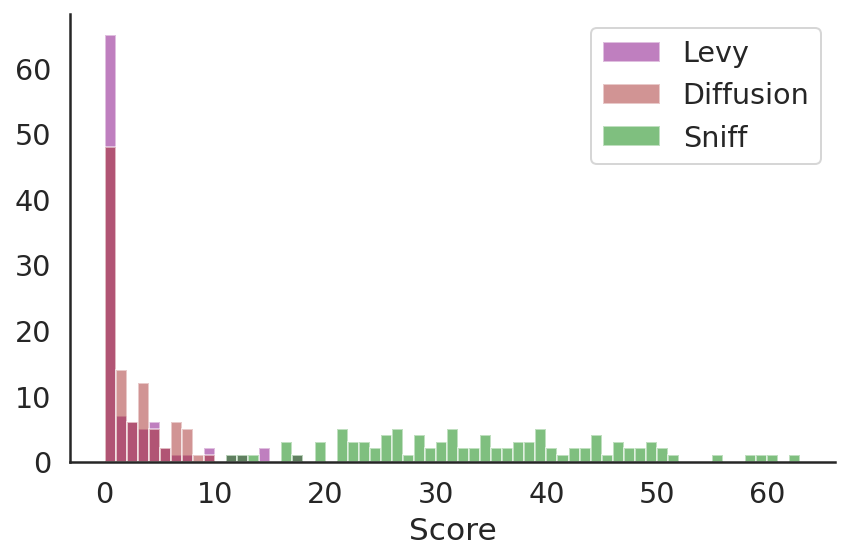

In [15]:
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.arange(min(s),max(s)+1,1))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

### Question 5 [10 pts]

Was your hypothesis correct? Compare the scores to those achieved in lab.

*Yes! My hypothesis was definitely correct at least for sniff! The average scores for sniff are a LOT higher than those achieved in lab. For Levy and Diffusion they I honestly cannot tell if it improves the scores, I believe it did a little but not a notable amount (especially compared to sniff). I just tried p pos = 0 after writing all this though and that was even better so... I guess I wasn't fully correct.*

### Question 6 [5 pts]

Can you imagine a situation in which setting _p pos_ to zero would be bad?  As in, could there exist an environment in which always strictly following the scent gradient is suboptimal? Use your imagination.

*If there is a shorter time limit (ex. you will die quickly if you dont get food very fast) then taking the long route with basically right angles will probably kill you because it will take up too much time. In this case gambling on the possibility of randomly accessing a short cut and making p pos =/= 0 may be worth it.*

## Submission

**DUE:** 5pm EST, Oct 12, 2021. Email the link to the completed notebook on your Github repository to the TA and me via Canvas.

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> *Maya Greenholt*